<a href="https://colab.research.google.com/github/eissana/transformer/blob/master/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"running on: {device}")

running on: cuda


# Data

## Read Data as Characters

In [2]:
with urlopen('https://raw.githubusercontent.com/eissana/transformer/master/data/hafez.txt') as f:
    words = f.read().decode('utf-16')
print(f'First few lines:\n {words[:84]}')

First few lines:
 غزل   ۱

الا يا ايها الساقی ادر کاسا و ناولها
که عشق آسان نمود اول ولی افتاد مشکل


In [3]:
print(f'Number of characters: {len(words)}')

Number of characters: 297408


In [4]:
chars = sorted(set(words))
nchars = len(chars)
# includes \n (new line), space, numbers and letters.
print(f'{nchars = }')
','.join(chars)

nchars = 48


'\n,\r, ,ء,آ,ا,ب,ت,ث,ج,ح,خ,د,ذ,ر,ز,س,ش,ص,ض,ط,ظ,ع,غ,ف,ق,ل,م,ن,ه,و,ي,پ,چ,ژ,ک,گ,ی,۰,۱,۲,۳,۴,۵,۶,۷,۸,۹'

## Tokenize Data

We map each character to an integer or token. With this mapping a text can be encoded into a vector of integers.

In [5]:
atoi = {c: i for i, c in enumerate(chars)}
itoa = {i: c for i, c in enumerate(chars)}

In [6]:
def encode(str):
    return [atoi[c] for c in str]

def decode(arr):
    return ''.join([itoa[i] for i in arr])

str = words[:84]
enc = encode(str)
print(enc)
print(decode(enc))

[23, 15, 26, 2, 2, 2, 39, 1, 0, 1, 0, 5, 26, 5, 2, 31, 5, 2, 5, 31, 29, 5, 2, 5, 26, 16, 5, 25, 37, 2, 5, 12, 14, 2, 35, 5, 16, 5, 2, 30, 2, 28, 5, 30, 26, 29, 5, 1, 0, 35, 29, 2, 22, 17, 25, 2, 4, 16, 5, 28, 2, 28, 27, 30, 12, 2, 5, 30, 26, 2, 30, 26, 37, 2, 5, 24, 7, 5, 12, 2, 27, 17, 35, 26]
غزل   ۱

الا يا ايها الساقی ادر کاسا و ناولها
که عشق آسان نمود اول ولی افتاد مشکل


We tokenize the whole text and use this dataset in the rest of development.

In [7]:
encdata = torch.tensor(encode(words), dtype=torch.long)
print(encdata[:84])

tensor([23, 15, 26,  2,  2,  2, 39,  1,  0,  1,  0,  5, 26,  5,  2, 31,  5,  2,
         5, 31, 29,  5,  2,  5, 26, 16,  5, 25, 37,  2,  5, 12, 14,  2, 35,  5,
        16,  5,  2, 30,  2, 28,  5, 30, 26, 29,  5,  1,  0, 35, 29,  2, 22, 17,
        25,  2,  4, 16,  5, 28,  2, 28, 27, 30, 12,  2,  5, 30, 26,  2, 30, 26,
        37,  2,  5, 24,  7,  5, 12,  2, 27, 17, 35, 26])


## Split Data

We use the first 80% of the text as the training dataset, the next 10% as the validation, and the last 10% as the test dataset.

In [11]:
nencdata = len(encdata)
ntrain, nvalid = int(0.8*nencdata), int(0.1*nencdata)

data = {'train': encdata[:ntrain],
        'valid': encdata[ntrain:ntrain+nvalid],
        'test': encdata[ntrain+nvalid:]}

print('Data split: ', end='')
print(f"{nencdata} = {len(data['train'])} + {len(data['valid'])} + {len(data['test'])}")

Data split: 297408 = 237926 + 29740 + 29742


# Model

We now build a transformer model. The model input is a block of text and the output of the model is a character that comes next.

Let's start with a simple bigram model that gets a character and predicts the next character. The bigrams are from a block of a text.

To generate training examples, we select a block from a text and generate all bigrams from the block. For instance, consider a text "A dog is barking." For a block-size of 5, suppose we selected 'og is '. All the bigrams are ('o', 'g'), ('g', ' '), (' ', 'i'), ('i', 's'), ('s', ' ').

## Model Parameters

In [38]:
block_size = 64
nembd = 96
nbatch = 64
nepoch = 5000
eval_size = 500
lr = 3e-4

## Utility Functions

In [39]:
def get_batch(data, nbatch, block_size):
    '''
    Generates a batch of examples.
    (x[i], y[i]) is a pair of consecutive characters in the text.
    '''
    indices = torch.randint(len(data)-block_size, (nbatch,))
    x = torch.stack([data[i:i+block_size] for i in indices]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in indices]).to(device)
    return x, y

In [40]:
x, y = get_batch(data['train'], nbatch=2, block_size=8)
x, y

(tensor([[ 2, 14, 30, 12,  2, 12, 26,  2],
         [30, 17, 37,  2, 35, 14, 12,  1]], device='cuda:0'),
 tensor([[14, 30, 12,  2, 12, 26,  2, 27],
         [17, 37,  2, 35, 14, 12,  1,  0]], device='cuda:0'))

In [41]:
def get_loss(logits, y):
    '''
    Computes cross-entropy loss, given logits and labels.
    '''
    B, T, C = logits.shape
    # F.cross_entropy expects size C, (B, C), or (B, C, ...)
    # logits shape is (B, T, C), so we flatten the first two dimensions.
    return F.cross_entropy(logits.view(B*T, C), y.view(B*T))

In [42]:
def train(model, data, nepoch=100, nbatch=20, block_size=8, lr=1e-3, losses=None):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    if losses is None:
        losses = {
            'train': [],
            'valid': [],
        }
    for _ in range(nepoch):
        x, y = get_batch(data['train'], nbatch=nbatch, block_size=block_size)

        logits = model(x)
        loss = get_loss(logits, y)
        losses['train'].append(loss.item())

        with torch.no_grad():
            x, y = get_batch(data['valid'], nbatch=nbatch, block_size=block_size)
            logits = model(x)
            vloss = get_loss(logits, y)
            losses['valid'].append(vloss.item())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return losses

In [43]:
def gen_text(model, block_size, max_size=100):
    '''
    Generates text using the model starting from nothing.
    '''
    # starting from '\n' char we generate text.
    x = torch.zeros((1, 1), dtype=torch.long, device=device)
    for _ in range(max_size):
        logits = model(x[:, -block_size:])
        # only consider the last logit
        logits = logits[:, -1, :]
        score = F.softmax(logits, dim=1)
        next_token = score.multinomial(1)
        x = torch.cat((x, next_token), dim=1)
    return x[0].tolist()

In [44]:
def nparameters(model):
    '''
    Returns the total number of model parameters.
    '''
    return sum([p.nelement() for p in model.parameters()])

## Bigram Model

In [ ]:
class Bigram(nn.Module):
    '''
    A simple bigram-based neural network, which gets a
    characater as input and predicts the next character.
    '''
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(nchars, nembd)
        self.linear = nn.Linear(nembd, nchars)

    def forward(self, x):
        out = self.token_emb(x)
        out = self.linear(out)
        return out

bigram = Bigram()

In [ ]:
nparameters(bigram)

3120

In [ ]:
logits = bigram(x)
loss = get_loss(logits, y)
print(f'loss of untrained model: {loss.item()}')
# Random model: p(c) = 1/nchars for every character c.
# loss -np.log([1/nchars]*nchars).mean() which is simplified to np.log(nchars).
print(f'expected loss of a random model: {np.log(nchars)}')

loss of untrained model: 4.157041549682617
expected loss of a random model: 3.871201010907891


In [ ]:
print(decode(gen_text(bigram, block_size, max_size=100)))


۸رونحفه۰ذضژژگ
ظیش۶۹مگث۲۸رظ۸ ضغوءذی۵ده۷عیلسژرذکچ۸۲۴گط۵
ثصمحضرر۳هآ۳ک
س۲یء۷ه۹۸پوخنيبذگ
ت۲آآف
ژآ


### Optimize Bigram Model

In [ ]:
bigram_losses = None

In [ ]:
bigram_losses = train(bigram, data, nepoch, nbatch, block_size, lr=lr, losses=bigram_losses)

In [ ]:
print(f"final training loss: {np.mean(bigram_losses['train'][-eval_size:])}")
print(f"final validation loss: {np.mean(bigram_losses['valid'][-eval_size:])}")

final training loss: 2.396427447795868
final validation loss: 2.4417529320716858


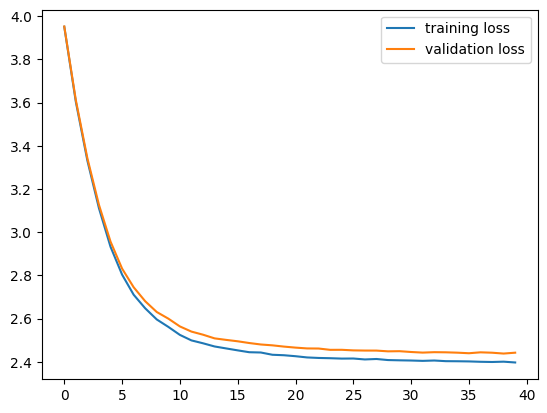

In [ ]:
plt.plot(torch.tensor(bigram_losses['train']).view(-1, eval_size).mean(axis=1));
plt.plot(torch.tensor(bigram_losses['valid']).view(-1, eval_size).mean(axis=1));
plt.legend(['training loss', 'validation loss']);

In [ ]:
print(decode(gen_text(bigram, block_size, max_size=100)))


شقايدل

د
ت چوی بزوی راز ن گردرو ط ت اه ست
مپه گسيانهر درانه م د
د
چه سرهت کش بی بانه کنهمران 


## Transformer Model

In [65]:
dropout = 0.3

### Self-Attention

In the bigram model, tokens do not communicate with each other, i.e., they predicts the next character independently without any knowledge of previous characters. The self-attention mechanis addresses this issue.

The simplest way for a token to communicate with previous one is to look at the average of all the previous tokens and the current token instead of the current token only. Although this is not the ideal method, it's constructive to understand how to implement this first.

To understand mathematical operations in self-attension, let's start with a simple example. Suppose we have a matrix $X$ of size $m\times n.$ We want to build a matrix $Y$, such that

$$Y_{ij}=\frac{1}{i+1}\sum_{k=0}^{i}X_{kj},\quad {\rm for}\quad i=0,1,\ldots,m-1,\quad j=0,1,\ldots,n-1.$$

This mean that $Y_{ij}$ is the average of $X_{0,j},\ldots,X_{i,j}.$ This operation can be achieved by matrix multiplication as $Y=LX$ where $L$ is an $m\times m$ triangular matrix defined as:

$$
L=
\begin{pmatrix}
1 & 0 & 0 & \ldots & 0\\
\frac{1}{2} & \frac{1}{2} & 0 & \ldots & 0\\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} & \ldots & 0\\
\vdots & \vdots & \vdots && \vdots\\
\frac{1}{m} & \frac{1}{m} & \frac{1}{m} & \ldots & \frac{1}{m}
\end{pmatrix}.
$$

One way to compute this matrix is $L={\rm Softmax(P)}$, where:

$$
P=
\begin{pmatrix}
0 & -\infty & -\infty & \ldots & -\infty\\
0 & 0 & -\infty & \ldots & -\infty\\
0 & 0 & 0 & \ldots & -\infty\\
\vdots & \vdots & \vdots && \vdots\\
0 & 0 & 0 & \ldots & 0
\end{pmatrix}.
$$

In our implementation, we often have a 3D tensor $X$ of size $m\times n\times p.$ We will illustrate how to apply this operation efficiently using matrix multiplication.

In [46]:
# Naive implementation.
X = torch.randn((4, 8, 3))
Y1 = torch.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        # The same as Y1[i, j, :] = torch.mean(X[i, :j+1, :], dim=0)
        Y1[i, j] = torch.mean(X[i, :j+1], dim=0)

# Efficient implementation.
tril = torch.tril(torch.ones(8, 8))
tril_normalized1 = tril / tril.sum(dim=1, keepdim=True)
# Y2(8x8) @ X(4x8x3)
# Since Y2 is 2D while X is 3D, @ operation will first
# broadcast Y2 to create 4x8x8. The result will have 4x8x3.
Y2 = tril_normalized1 @ X

# Another efficient implementation.
tril_normalized2 = torch.zeros_like(tril)
tril_normalized2 = tril_normalized2.masked_fill(tril == 0, float('-inf'))
tril_normalized2 = F.softmax(tril_normalized2, dim=1)
print(f'Are both normalizations equal? {torch.allclose(tril_normalized1, tril_normalized2)}')
Y3 = tril_normalized2 @ X

torch.allclose(Y1, Y2), torch.allclose(Y1, Y3)

Are both normalizations equal? True


(False, False)

In the bigram model, we only use the information about the current token to determine the next token. In the self-attention mechanism, however, we use the information of the previous tokens in addition to that of the current token. As we discussed we aggregate the information of previous tokens using the mean of the model weights corresponding to those tokens. This is not ideal as we treat all previous tokens the same. In the following, we discuss ways to improve it.

A self-attention module contains a head $H$, a query $Q$, and a key $K$. A head has a size $h$ called head-size. Each query and key is a vector of size $h$. Each token is associated with a query and key.

For any token $i$, we compute $Q_i\cdot K_j$, for $j=0,1,\ldots,i$, which represent the relevance of token $i$ to each previous token $j$.

In [66]:
class Head(nn.Module):
    '''
    Self-attention head layer.
    '''
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(nembd, head_size, bias=False)
        self.key = nn.Linear(nembd, head_size, bias=False)
        self.value = nn.Linear(nembd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        # tril is not a model parameter so we register it as a buffer.
        # block_size is the maximum size. The actual size can be smaller.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        _, T, C = x.shape
        query = self.query(x)
        key = self.key(x)
        weights = query @ key.transpose(-2, -1) * C**-0.5

        # The time dimension can be smaller than the block-size.
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        value = self.value(x)
        out = weights @ value

        return out

In [112]:
class Transformer(nn.Module):
    '''
    A simple transformer model for building a character-level
    language model using a single self-attention head.
    '''
    def __init__(self, head_size):
        super().__init__()
        self.token_emb = nn.Embedding(nchars, nembd)
        self.position_emb = nn.Embedding(block_size, nembd)
        self.head = Head(head_size)
        self.linear = nn.Linear(head_size, nchars)

    def forward(self, x):
        _, T = x.shape
        # x.shape == (nbatch, block_size, nchars)
        # token_emb.shape == (nbatch, block_size, nembd)
        token_emb = self.token_emb(x)
        # position_emb.shape == (nbatch, block_size, nembd)
        position_emb = self.position_emb(torch.arange(T, device=device))
        # out.shape == (nbatch, block_size, nembd)
        out = token_emb + position_emb
        # out.shape == (nbatch, block_size, nembd)
        out = self.head(out)
        # out.shape == (nbatch, block_size, nchars)
        out = self.linear(out)

        return out

transformer = Transformer(head_size=16).to(device)

In [113]:
nparameters(transformer)

5936

### Optimize Single-Head Transformer

In [ ]:
transformer_losses = None

In [ ]:
transformer_losses = train(transformer, data, nepoch, nbatch, block_size, lr=lr, losses=transformer_losses)

In [ ]:
print(f"final training loss: {np.mean(transformer_losses['train'][-eval_size:])}")
print(f"final validation loss: {np.mean(transformer_losses['valid'][-eval_size:])}")

final training loss: 2.4732484102249144
final validation loss: 2.509839653968811


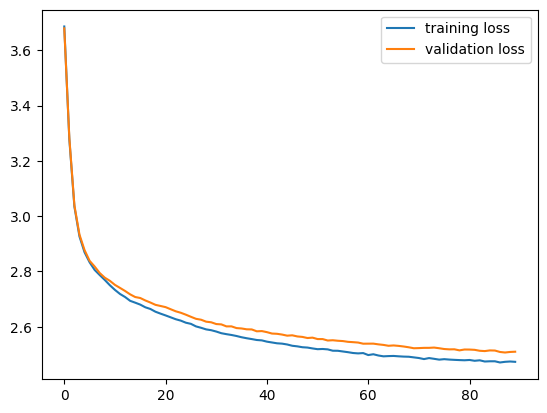

In [ ]:
plt.plot(torch.tensor(transformer_losses['train']).view(-1, eval_size).mean(axis=1));
plt.plot(torch.tensor(transformer_losses['valid']).view(-1, eval_size).mean(axis=1));
plt.legend(['training loss', 'validation loss']);

In [ ]:
print(decode(gen_text(transformer, block_size, max_size=100)))


گرافن د مد خ نظر نخره


ز
که م
بيذر ن قتی اسهی حاحنسه

ز ت م آرداجاابانقتمشاسراگذولن
گر فاير


### Multi-Head Attention

A multi-head attention layer is just a multiple self-attention heads running in parallel. For completeness, we also add a feed-forward layer as described in the Attention paper.

We create a block layer which contains a self-attention layer followed by a feed-forward layer. Then we add multiple blocks sequentially in the network.

In [67]:
nhead = 6
nblock = 6

In [68]:
class MultiHead(nn.Module):
    def __init__(self, nhead, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(nhead)])
        self.proj = nn.Linear(nembd, nembd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

In [69]:
class FeedForward(nn.Module):
    def __init__(self, fain_in, fan_out):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(fain_in, 4 * fan_out),
            nn.ReLU(),
            nn.Linear(4 * fan_out, fan_out),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        out = self.ff(x)
        return out

In [70]:
class Block(nn.Module):
    def __init__(self, nembd, nhead):
        super().__init__()
        # self-attention heads
        self.sa = MultiHead(nhead, nembd//nhead)
        self.sa_layer_norm = nn.LayerNorm(nembd)
        # feed-forward network
        self.ff = FeedForward(nembd, nembd)
        self.ff_layer_norm = nn.LayerNorm(nembd)


    def forward(self, x):
        out = x
        # deep residual network
        out = out + self.sa(self.sa_layer_norm(out))
        out = out + self.ff(self.ff_layer_norm(out))
        return out

In [71]:
class Transformer(nn.Module):
    '''
    A simple transformer model for building a character-level
    language model using multiple self-attention heads.
    '''
    def __init__(self, nhead, nblock):
        super().__init__()
        self.token_emb = nn.Embedding(nchars, nembd)
        self.position_emb = nn.Embedding(block_size, nembd)
        self.blocks = nn.Sequential(*[Block(nembd, nhead) for _ in range(nblock)])
        self.layer_norm = nn.LayerNorm(nembd)
        self.linear = nn.Linear(nembd, nchars)

    def forward(self, x):
        _, T = x.shape
        # x.shape == (nbatch, block_size, nchars)
        # token_emb.shape == (nbatch, block_size, nembd)
        token_emb = self.token_emb(x)
        # position_emb.shape == (nbatch, block_size, nembd)
        position_emb = self.position_emb(torch.arange(T, device=device))
        # out.shape == (nbatch, block_size, nembd)
        out = token_emb + position_emb
        # out.shape == (nbatch, block_size, nembd)
        out = self.blocks(out)
        out = self.layer_norm(out)
        # out.shape == (nbatch, block_size, nchars)
        out = self.linear(out)

        return out

multihead_transformer = Transformer(nhead, nblock).to(device)

In [72]:
nparameters(multihead_transformer)

684912

### Optimize Multi-Head Transformer

In [73]:
multihead_losses = None

In [85]:
multihead_losses = train(multihead_transformer, data, nepoch, nbatch, block_size, lr=lr, losses=multihead_losses)

In [86]:
print(f"final training loss: {np.mean(multihead_losses['train'][-eval_size:])}")
print(f"final validation loss: {np.mean(multihead_losses['valid'][-eval_size:])}")

final training loss: 1.562359969139099
final validation loss: 1.8432950417995453


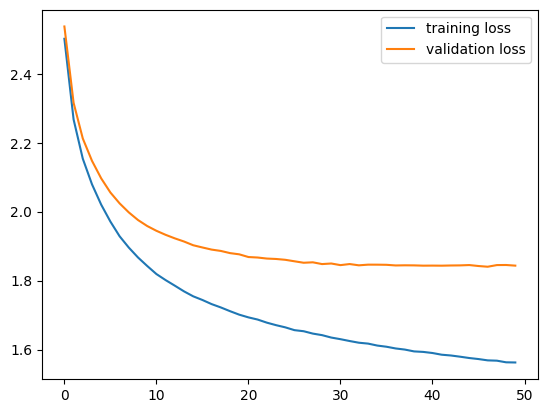

In [87]:
plt.plot(torch.tensor(multihead_losses['train']).view(-1, eval_size).mean(axis=1));
plt.plot(torch.tensor(multihead_losses['valid']).view(-1, eval_size).mean(axis=1));
plt.legend(['training loss', 'validation loss']);

In [88]:
print(decode(gen_text(multihead_transformer, block_size, max_size=1000)))



تجران فجرا دل دانون که کلاه کنند
گره تو از شعر صحب بنيان آوريد

سمن باشد که بی توان چون تو بيابانم
که مرا نيست هجرت خرابد بر تب کجا

صبا اگر مشکل می لعل فروخت چو راه حافظ
مرايم
باشد ز درد وقت عافلان پيدا گفتيم

مغلطه ابروی آيد که صقاحی ای زير مغان
که حضرت ور نه سير نياز نباشد

جام می رسد به و ترايی که نقشد کس
که به من بی وردی غم خود نه من را زر تا

در عالم بار غيرت بخندی به جوای کنم
جان هيچ زان بر فتاد رضای تو باشد

زلف تو ياد قرار عمرم کشتی ز هر عمران
با چشمگيه بدنام طريق الاب

اين دام زلف تسبيلين عيان چمن است
من بی بشيم همچو حسن و محماليست

ای دلقبا دل قدح گير و مدام قضا
زير شب و زير ره در شيوه دربر نبات

ديديم محصول گم از ولعظمم و زناع جان شد وطنش
شيراب مبادان اقرار عمر تو به يک

دلم پاش و خوش آفت و سببی باز باش کارغند
هميشه ای بی پيش من و گل بارگير

برو که اين با مسکدرکش دريش
طلبی راه از ابر نظرباز چون گذارد

با ضمين که دل زورشت نباشم به کوشی
اين من او همه روی تو چون عنايت مساز

آه که چنين آستان تو دست کشيد به کدام
عقش گمشيد حافظ انداخت بف
